In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import graph_statistics
import utils
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot)

# Statistics

In [2]:
statistic_fns = {#'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 #'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 #'Power Law α':graph_statistics.power_law_alpha,
                 #'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 #'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

## Ours

In [3]:
eval_ours = Evaluation(experiment_root='../logs/CORA-ML/Ours/',
                       statistic_fns=statistic_fns)

In [4]:
eval_ours.compute_statistics()

In [5]:
eval_ours.aggregate_statistics(num_bins=10)

In [6]:
eval_ours.statistics['Edge Overlap (%)'][-1]

array([0.00442282, 0.09479581, 0.34542238, 0.45717234, 0.55889724,
       0.61831048, 0.66637181, 0.71384343, 0.73979065, 0.76146248,
       0.79006339, 0.80967124, 0.81866431, 0.83384933, 0.84357954,
       0.85330974, 0.86171311, 0.8708536 , 0.8799941 , 0.88235294])

## Netgan

In [7]:
eval_netgan = Evaluation(experiment_root='../logs/CORA-ML/baseline_NetGan/',
                         statistic_fns=statistic_fns)

In [8]:
eval_netgan.compute_statistics()

In [9]:
eval_netgan.aggregate_statistics(num_bins=10)

## Forge Adjacency 

In [10]:
eval_fa = Evaluation(experiment_root='../logs/CORA-ML/baseline_FA/',
                     statistic_fns=statistic_fns)

In [11]:
eval_fa.compute_statistics()

In [12]:
eval_fa.aggregate_statistics(num_bins=10)

## Forge transition

In [13]:
eval_ft = Evaluation(experiment_root='../logs/CORA-ML/baseline_FT/',
                     statistic_fns=statistic_fns)

In [14]:
eval_ft.compute_statistics()

In [15]:
eval_ft.aggregate_statistics(num_bins=10)

## Configuration Model

In [16]:
eval_conf = Evaluation(experiment_root='../logs/CORA-ML/baseline_conf/',
                       statistic_fns=statistic_fns)

In [17]:
eval_conf.compute_statistics()

In [18]:
eval_conf.aggregate_statistics(num_bins=10)

# Summary

In [19]:
tabular = tabular_from_statistics(EO_criterion=0.5,
                                  statistics={'ours': eval_ours.mean_std,
                                              'netgan': eval_netgan.mean_std,
                                              'fa': eval_fa.mean_std,
                                              'ft': eval_ft.mean_std,
                                              'conf': eval_conf.mean_std
                                             })

In [39]:
def df_from_tabular(tabular, keys=None):
    mean_dicts, std_dicts = tabular
    string_tabular = {}
    for (model_key, mean_dict) in mean_dicts.items():
        std_dict = std_dicts[model_key]
        string_tabular[model_key] = {}
        for (statistc_key, mean) in mean_dict.items():
            std = std_dict[statistc_key]
            string_tabular[model_key][statistc_key] = (f'{mean:.3f} \u00B1 {std:.3f}')
    df = pd.DataFrame(string_tabular.values(), string_tabular.keys())
    if keys is not None:
        df = df[keys]
    return df

In [20]:
df = df_from_tabular(tabular)

In [21]:
df

,Claw Count,Square Count,Wedge Count,Edge Overlap (%),ROC-AUC Score,Average Precision,Time (s)
ours,1738945.600 ± 238717.883,6755.950 ± 505.775,81647.350 ± 2806.074,0.551 ± 0.008,0.925 ± 0.005,0.933 ± 0.005,14.253 ± 0.175
netgan,2880526.182 ± 436481.149,9146.182 ± 485.580,109737.818 ± 3654.006,0.548 ± 0.029,0.924 ± 0.003,0.927 ± 0.004,6044.619 ± 707.466
fa,489182.050 ± 61525.613,1128.950 ± 78.341,48245.750 ± 930.903,0.525 ± 0.005,0.565 ± 0.000,0.660 ± 0.000,2.193 ± 0.057
ft,724098.000 ± 104610.585,1547.600 ± 82.679,57796.250 ± 1475.635,0.560 ± 0.005,0.706 ± 0.000,0.793 ± 0.000,2.031 ± 0.106
conf,2693617.350 ± 89329.125,3148.600 ± 205.397,97634.150 ± 905.817,0.504 ± 0.001,NaN,NaN,0.115 ± 0.013


# True graph

In [22]:
_A_obs = load_npz('../data/CORA_ML.npz')

In [23]:
val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [24]:
original_statistics = compute_original_statistics(original_graph=train_graph, statistic_fns=statistic_fns)

# BOXPLOTS

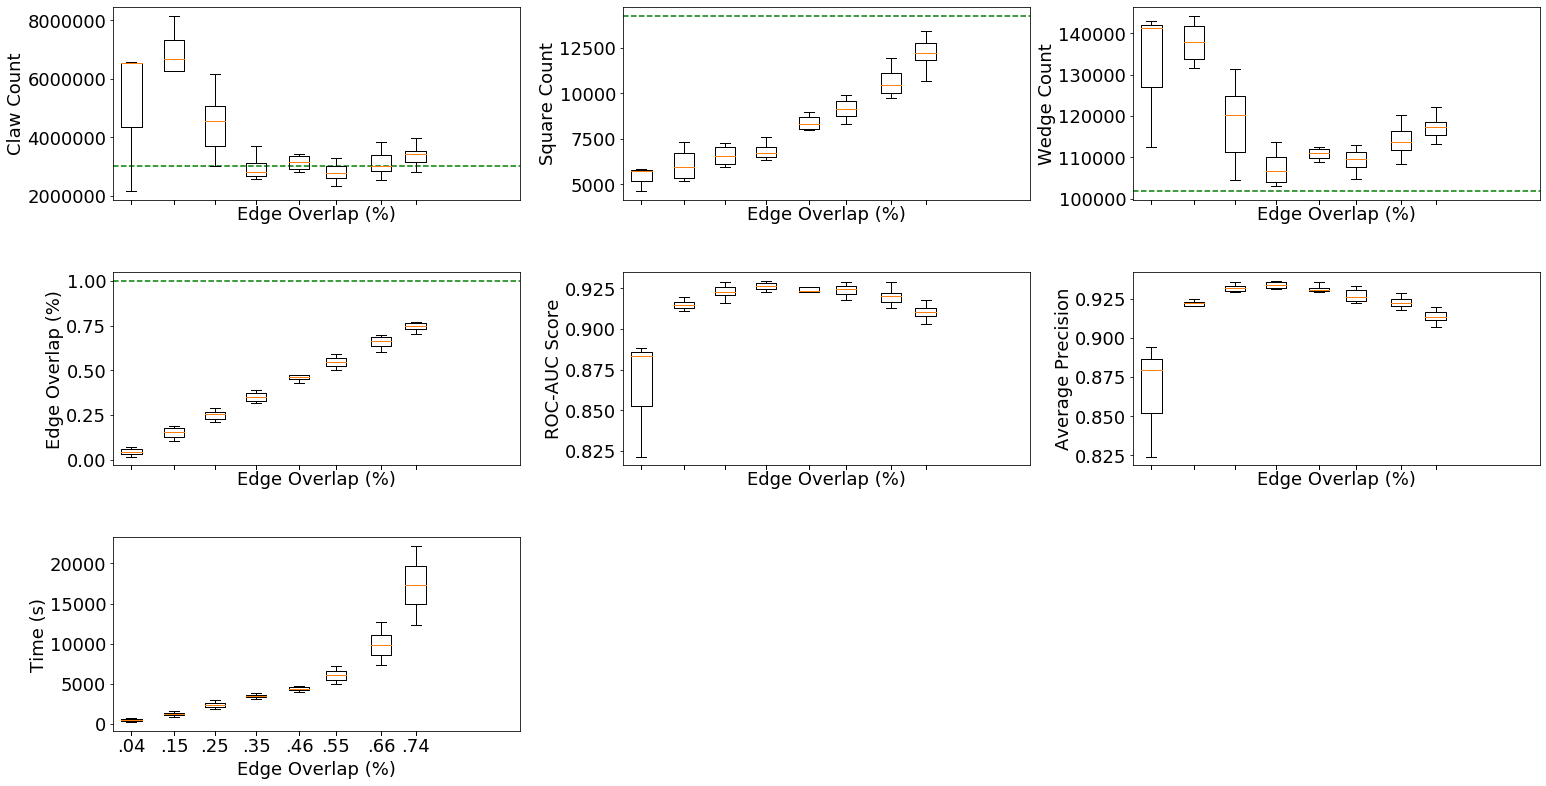

In [27]:
boxplot(statistics_binned=eval_netgan.statistics_binned, original_statistics=original_statistics, save_path='../fig/ours.pdf')

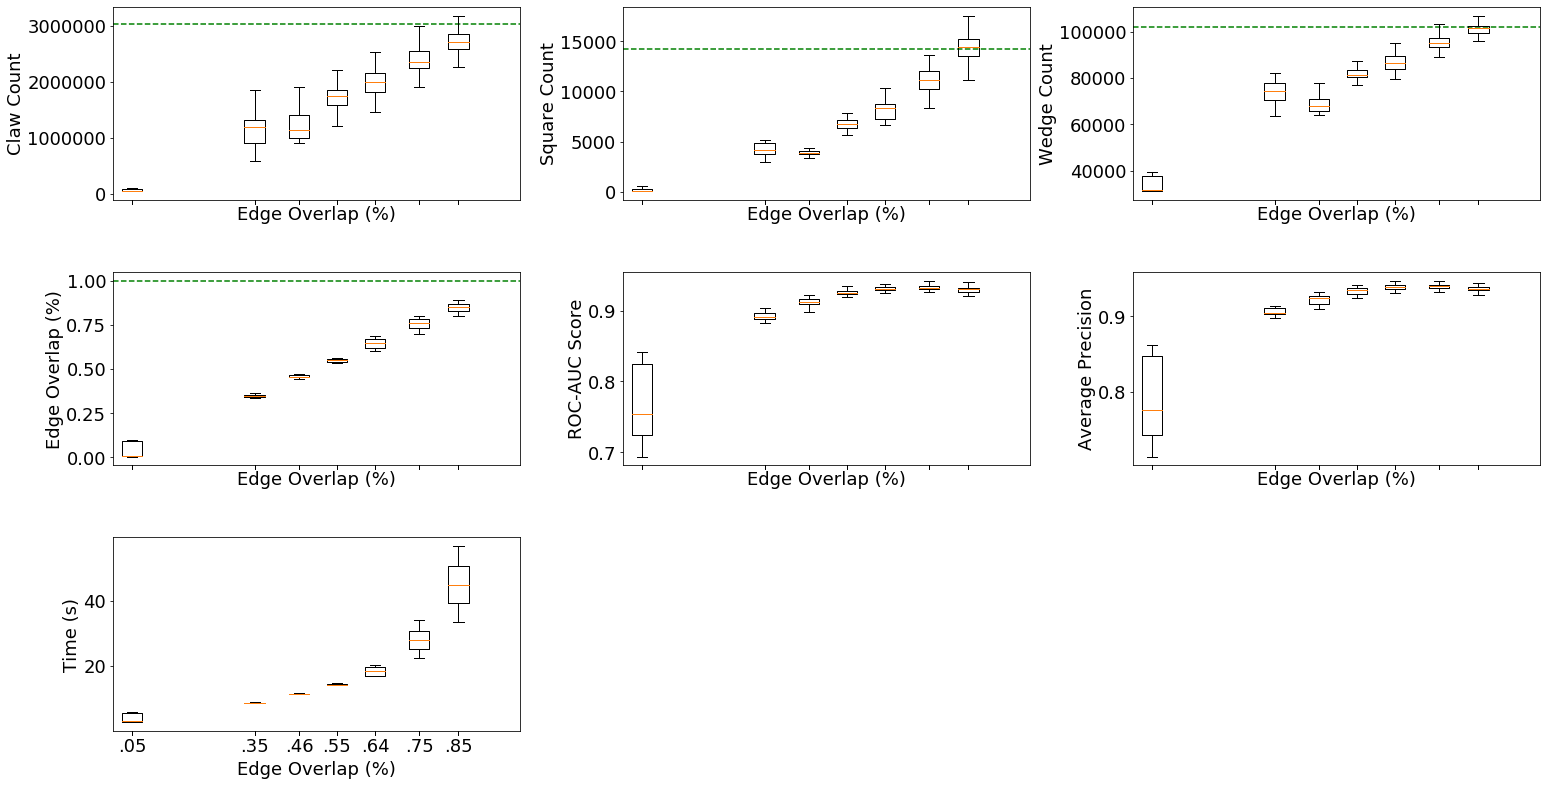

In [26]:
boxplot(statistics_binned=eval_ours.statistics_binned, original_statistics=original_statistics)